In [1]:
!pip install gupload

     |████████████████████████████████| 81kB 9.3MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
ERROR: earthengine-api 0.1.266 has requirement google-api-python-client<2,>=1.12.1, but you'll have google-api-python-client 1.7.10 which is incompatible.
  Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
  Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8


In [2]:
import pandas as pd
import numpy as np
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials
from sklearn.metrics import mean_squared_error, make_scorer
from xgboost import XGBRegressor
import xgboost
from sklearn.model_selection import RandomizedSearchCV
import gc
import pickle
import sys

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
# Read Preprocessed data
id_dataset = '1Y_cNEgLNsATfL8BGb-Ovz4cpWqxy72JD'
data = drive.CreateFile({'id':id_dataset})   
data.GetContentFile('df_processed.pkl')

In [5]:
df = pd.read_pickle('df_processed.pkl')

# Train / Validation

In [6]:
X_train = df[df["date_block_num"]<33].drop("target",axis=1)
X_val   = df[df["date_block_num"]==33].drop("target",axis=1)
X_test  = df[df["date_block_num"]==34].drop("target",axis=1)

y_train = df[df["date_block_num"]<33].target
y_val   = df[df["date_block_num"]==33].target

In [7]:
del df
gc.collect();

# XGBOOST

In [8]:
xgb_params = {
    'lambda': np.linspace(0,0.5), 
    'gamma': np.linspace(0,0.5),
    'alpha': np.linspace(0,0.5),
    'objective': ['reg:squarederror'],
    'colsample_bytree': np.linspace(0.7,0.99),
    'subsample': np.linspace(0.7,0.99), 
    'min_child_weight': range(10),
    'eta': np.linspace(0,0.1),
    'learning_rate': np.linspace(0.01,0.08),
    'n_estimators': range(50,500,50),
    'max_depth': range(4,9),
    'tree_method': ['gpu_hist'], 
    'verbosity':[2],
    'nthread':[0]
}

In [9]:
xgb_randomized_search = {"PARAMS":["a"],"TRAIN_SCORE":[999], "VAL_SCORE":[999]}

n_iter = 50
best_model = []
for i in range(n_iter):
  print(f"Iteration: {i+1}")
  params = {}
  for x,y in xgb_params.items():
      np.random.seed = 42
      #Randomized Search
      params[x] = np.random.choice(y)

  #Train the model
  xgb = XGBRegressor(**params)
  xgb.fit(X_train,y_train)
  train_score = np.sqrt(mean_squared_error(y_train,xgb.predict(X_train)))
  val_score   = np.sqrt(mean_squared_error(y_val,xgb.predict(X_val)))
  #Best Model
  if val_score < min(xgb_randomized_search["VAL_SCORE"]):
    best_model = xgb
  #Append values
  xgb_randomized_search["PARAMS"].append(params)
  xgb_randomized_search["TRAIN_SCORE"].append(train_score)
  xgb_randomized_search["VAL_SCORE"].append(val_score)
  print(f"> Train Score: {train_score}\n> Validation Score: {val_score}")
  print("...............................")
  del xgb, train_score, val_score
  gc.collect();
  
xgb_randomized_search = pd.DataFrame(xgb_randomized_search).drop(0)

Iteration: 1
> Train Score: 0.8440886735916138
> Validation Score: 0.8019803166389465
...............................
Iteration: 2
> Train Score: 0.7844635844230652
> Validation Score: 0.8049607872962952
...............................
Iteration: 3
> Train Score: 0.8872243762016296
> Validation Score: 0.8198109865188599
...............................
Iteration: 4
> Train Score: 0.8427047729492188
> Validation Score: 0.8026437163352966
...............................
Iteration: 5
> Train Score: 0.8465012311935425
> Validation Score: 0.8015182614326477
...............................
Iteration: 6
> Train Score: 0.8642865419387817
> Validation Score: 0.8072331547737122
...............................
Iteration: 7
> Train Score: 0.8593423366546631
> Validation Score: 0.806428849697113
...............................
Iteration: 8
> Train Score: 0.8483254909515381
> Validation Score: 0.8018239140510559
...............................
Iteration: 9
> Train Score: 0.8419557213783264
> Validati

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


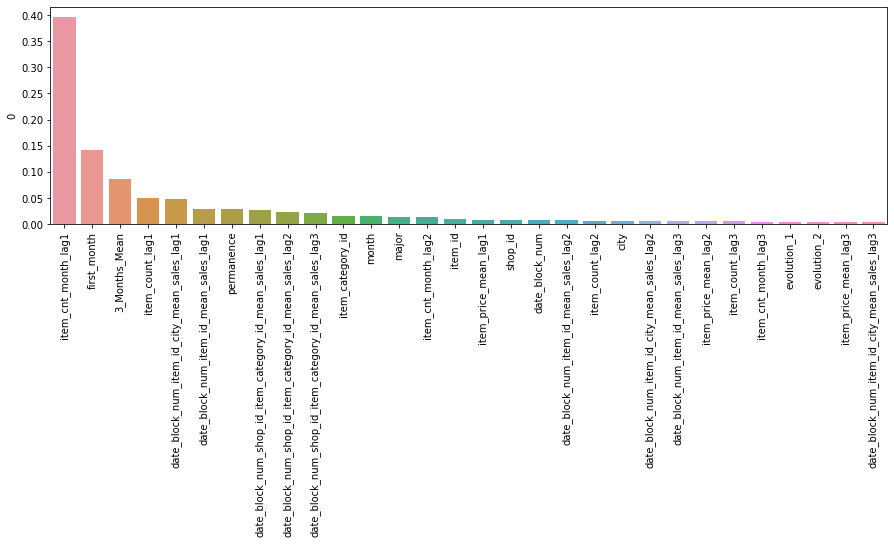

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
feat_importance = pd.DataFrame(best_model.feature_importances_/best_model.feature_importances_.sum()\
                                        , index=X_train.columns).sort_values(by=0,ascending=False)
plt.figure(figsize=(15,4))
sns.barplot(feat_importance.index, feat_importance[0])
plt.xticks(rotation=90);

In [11]:
pickle.dump(best_model,open("xgb.pkl",'wb'))
!gupload --to '1fUe3r9HhiN576xtpLTxp7LBwIbK_mpqp' xgb.pkl

Uploading file: xgb.pkl


In [12]:
xgb_randomized_search.to_csv("xgb_randomized_search.csv")
!gupload --to '1fUe3r9HhiN576xtpLTxp7LBwIbK_mpqp' xgb_randomized_search.csv

Uploading file: xgb_randomized_search.csv


In [13]:
preds = best_model.predict(X_test)
submit = pd.DataFrame(preds.clip(0,20))
submit.index.name = "ID"
submit.rename(columns={0:"item_cnt_month"},inplace=True)

In [14]:
submit.to_csv("submission_xgb.csv")

LB score: 0.90476